In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline

# some pandas options
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

pd.set_option("display.expand_frame_repr", False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

sats = 100000000

In [2]:
%%bigquery txs
SELECT txs.*, mem.first_seen, mem.last_seen FROM `bitcoin-data-analysis-320014.transaction_analysis.txs_two_or_less_outputs` txs JOIN
(SELECT tx_hash
     , MIN(first_seen_block_height) AS first_seen
     , MAX(file_block_height) AS last_seen
FROM (
SELECT `index` AS tx_hash
     , height AS first_seen_block_height
     , REGEXP_EXTRACT(_FILE_NAME, r'[^_]*', 44) AS file_block_height 
  FROM `bitcoin-data-analysis-320014.transaction_analysis.mempool_snapshots_ext` 
) GROUP BY 1) mem ON txs.tx_hash = mem.tx_hash
WHERE DATE(txs.block_timestamp)= '2021-02-02'

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330262/330262 [01:30<00:00, 3648.49rows/s]


In [8]:
txs['block_wait_time'] = txs['block_number'] - txs['first_seen']

<AxesSubplot:ylabel='Frequency'>

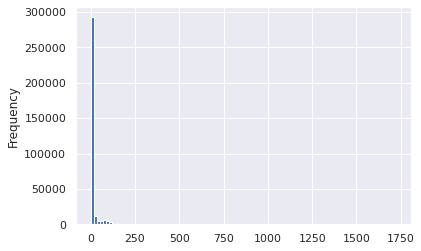

In [10]:
txs['block_wait_time'].plot(kind='hist', bins=100)

In [11]:
txs['block_wait_time'].describe()

count    330262.000000
mean          9.730911
std          27.406746
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        1719.000000
Name: block_wait_time, dtype: float64

In [14]:
txs.sort_values(by='block_wait_time', ascending=False)

,tx_hash,block_timestamp,block_number,input_count,output_count,input_type,output_type,input_value,output_value,payment_value,change_value,mining_fee,mining_fee_rate,payment_usd,change_usd,fee_usd,block_fullness,heuristic,first_seen,last_seen,block_wait_time
286974,d96a0da65169739552ab308fc890243ae59baa6466118b80cde339ded6e108aa,2021-02-02 23:39:03+00:00,668817,1,2,witness_v0_keyhash,mixed_outputs,6100,5816,1269.0,4547.0,284,2.000000,0.44,1.57,0.10,0.998414,matching_address_type,667098,668816,1719
121692,0f31c3a10e7f4d49489e6bacd78e5fc9f07e5fe88c05a8819dc8b6ecc470f7fd,2021-02-02 23:39:03+00:00,668817,1,2,witness_v0_keyhash,mixed_outputs,5411,5127,2826.0,2301.0,284,2.000000,0.98,0.79,0.10,0.998414,matching_address_type,667098,668816,1719
87445,d6f7785dd28941cb22a9887105c6bcd83576f474f835f356b2b6013a513352af,2021-02-02 11:39:19+00:00,668737,2,2,pubkeyhash,mixed_outputs,232684,231940,220203.0,11737.0,744,2.010811,76.02,4.05,0.26,0.998780,matching_address_type,667026,668736,1711
69372,a08729e044dbb74861651dfec1401a2dc89a11eac8ac8b351d3032b9f5a69800,2021-02-02 15:25:15+00:00,668766,1,2,witness_v0_keyhash,witness_v0_keyhash,1438884,1438602,NaN,NaN,282,2.000000,NaN,NaN,0.10,0.998527,None,667093,668765,1673
232675,254daea7892c7a36e1e032ed4b4511038e64cba6aba3fd3bea00b5095d6488fc,2021-02-02 04:28:29+00:00,668694,2,2,scripthash,scripthash,282168,281656,NaN,NaN,512,2.000000,NaN,NaN,0.18,1.000159,None,667098,668693,1596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205768,254bdfe6370cd3ad6176d4f4f73470a795664dc82d7ade1150668053f89abfef,2021-02-02 00:31:25+00:00,668671,1,1,witness_v0_keyhash,scripthash,239664,225678,225678.0,0.0,13986,126.000000,77.91,0.00,4.83,0.999110,single_output,668670,668670,1
205769,448d04b8b6f9b98b7cf89f10267771ba5029606d88ed87e7f388c9a28e4bb742,2021-02-02 00:31:25+00:00,668671,7,1,mixed_inputs,witness_v0_scripthash,4507117,4339400,4339400.0,0.0,167717,166.716700,1498.04,0.00,57.90,0.999110,single_output,668670,668670,1
205770,6937d4cabcffd520988f29f42e9a607e32777b4530be1a2229dd20e9c03eb531,2021-02-02 00:31:25+00:00,668671,1,1,witness_v0_keyhash,scripthash,25000,11377,11377.0,0.0,13623,122.729730,3.93,0.00,4.70,0.999110,single_output,668670,668670,1
205771,6a0f799285506eab146d559f7a72b73cdaf1308af16b2d3d1c80123b4ea0e268,2021-02-02 00:31:25+00:00,668671,1,1,pubkeyhash,pubkeyhash,9093377,9068356,9068356.0,0.0,25021,130.317708,3130.55,0.00,8.64,0.999110,single_output,668670,668670,1


In [15]:
txs.size

6935502

In [16]:
txs[txs['block_wait_time'].isnull()].size

0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='mining_fee_rate', ylabel='block_wait_time'>

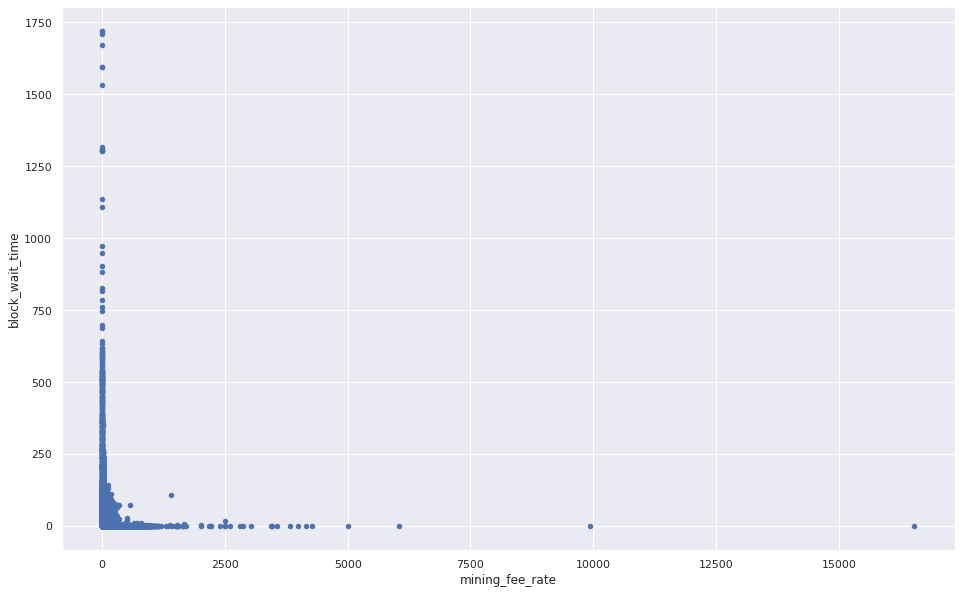

In [27]:
txs.plot.scatter(
    x='mining_fee_rate', 
    y='block_wait_time', 
    figsize=(16,10),
    #c='mining_fee',
    #colormap='viridis',
)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='mining_fee_rate', ylabel='block_wait_time'>

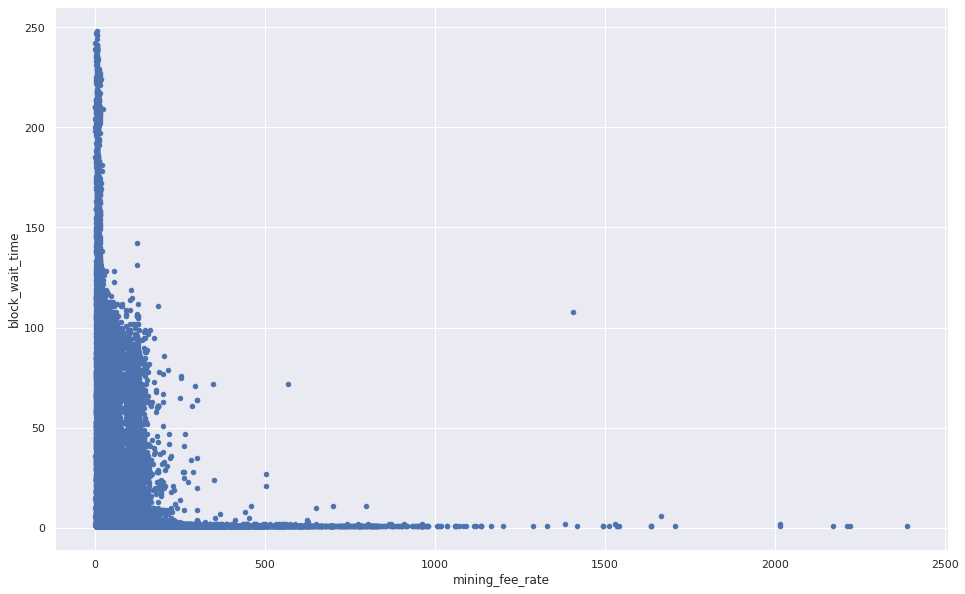

In [26]:
txs[
    (txs.block_wait_time < 250) & 
    (txs.mining_fee_rate < 2500)
].plot.scatter(
    x='mining_fee_rate', 
    y='block_wait_time',
    #c='mining_fee',
    #colormap='viridis',
    figsize=(16,10))